#OBJECTIVE OF THE NOTEBOOK

ALL THESE EXPERIMENTS ARE TO BE COMPARED WITH MODEL1 - ATTENTION OF 1_EXPLORATIVEMODELS_GLOVE :

- Total params: 8,029,458
- Trainable params: 167,858
- Non-trainable params: 7,861,600
- val_start_categorical_accuracy : 0.3670681416988373
- val_end_categorical_accuracy : 0.4037668704986572
- mean categorical accuracy over val_set : 0.38541750609874725

In [1]:
!git clone https://github.com/federicozanini/NLP.git

Cloning into 'NLP'...
remote: Enumerating objects: 134, done.
remote: Counting objects: 100% (47/47), done.
remote: Compressing objects: 100% (37/37), done.
remote: Total 134 (delta 13), reused 41 (delta 7), pack-reused 87
Receiving objects: 100% (134/134), 314.74 MiB | 40.31 MiB/s, done.
Resolving deltas: 100% (38/38), done.
Checking out files: 100% (31/31), done.


In [2]:
import tensorflow as tf
import os
import numpy as np
import pandas as pd

In [5]:
# LOADING DATA FROM OUR PICKLEs

path = "./NLP/FINAL_DATASETS/VERSION_IDX_BY_WORD/{}.zip"

df_train = pd.read_pickle(path.format("df_train"), compression='zip')
df_val = pd.read_pickle(path.format("df_val"), compression='zip')

In [6]:
import json

# LOADING VOCABULARIES FROM OUR JSONs
idx_to_word = {}
word_to_idx = {}

with open('./NLP/vocabularies/1_2_3_initialmodels/glove/idx_to_word.json') as f:
    idx_to_word = json.load(f)
with open('./NLP/vocabularies/1_2_3_initialmodels/glove/word_to_idx.json') as f:
    word_to_idx = json.load(f)

In [7]:
def load_data(df, batch_size):

    batch_counter = 0

    while True:
        # of a batch:
        contexts = []
        questions  = []
        answer_starts = []
        answer_ends = []
        # to select rows that go into a certain batch
        from_row = batch_counter*batch_size
        to_row = (batch_counter+1)*batch_size #NB IT DOES NOT BREAK IF INDEX OUT OF RANGE :)
        
        for i, row in df[from_row:to_row].iterrows():
        #COLUMN NAMES : question_list, context_list, answer_start, answer_end
            # QUESTIONS EMBEDDING
            question = []
            # formatting single question
            for word in row['question_list']:
                question.append(word_to_idx[word])
            # adding it to the questions' column
            questions.append(question)
            
            # CONTEXTS EMBEDDING
            context = []
            # formatting single context 
            for word in row['context_list']:
                context.append(word_to_idx[word])
            # adding it to the contexts' column
            contexts.append(context)

            # OUTPUTS EMBEDDING
            # formatting outputs (ONE HOT ENCODING)
            start = np.zeros(shape=(len(context),))
            start[row['answer_start']] = 1
            end  = np.zeros(shape=(len(context)))
            end[row['answer_end']] = 1
            # adding it to the outputs' columns
            answer_starts.append(start)
            answer_ends.append(end)

        
        contexts = tf.keras.preprocessing.sequence.pad_sequences(contexts, dtype="float32", padding="post")
        questions = tf.keras.preprocessing.sequence.pad_sequences(questions, dtype="float32", padding="post")
        answer_starts = tf.keras.preprocessing.sequence.pad_sequences(answer_starts, dtype="float32", padding="post")
        answer_ends = tf.keras.preprocessing.sequence.pad_sequences(answer_ends, dtype="float32", padding="post")
        
        if batch_counter < df.shape[0]//batch_size:
          batch_counter += 1
        else:
          batch_counter = 0


        yield  (questions, contexts), (answer_starts, answer_ends)

In [8]:
def encode_val(df):
    contexts = []
    questions  = []
    answer_starts = []
    answer_ends = []
    
    for i, row in df.iterrows():
    #COLUMN NAMES : question_list, context_list, answer_start, answer_end
        # QUESTIONS EMBEDDING
        question = []
        # formatting single question
        for word in row['question_list']:
            question.append(word_to_idx[word])
        # adding it to the questions' column
        questions.append(question)
        
        # CONTEXTS EMBEDDING
        context = []
        # formatting single context 
        for word in row['context_list']:
            context.append(word_to_idx[word])
        # adding it to the contexts' column
        contexts.append(context)

        # OUTPUTS EMBEDDING
        # formatting outputs (ONE HOT ENCODING)
        start = np.zeros(shape=(len(context),))
        start[row['answer_start']] = 1
        end  = np.zeros(shape=(len(context)))
        end[row['answer_end']] = 1
        # adding it to the outputs' columns
        answer_starts.append(start)
        answer_ends.append(end)

    
    contexts = tf.keras.preprocessing.sequence.pad_sequences(contexts, dtype="float32", padding="post")
    questions = tf.keras.preprocessing.sequence.pad_sequences(questions, dtype="float32", padding="post")
    answer_starts = tf.keras.preprocessing.sequence.pad_sequences(answer_starts, dtype="float32", padding="post")
    answer_ends = tf.keras.preprocessing.sequence.pad_sequences(answer_ends, dtype="float32", padding="post")

    return (questions, contexts), (answer_starts, answer_ends)

In [9]:
df_valENC = encode_val(df_val)

In [10]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
plt.style.use('seaborn-whitegrid')

def draw_graphs(history, logs_dir):

    epochs = len(history['loss'])
    x = np.arange(0, epochs) + 1

    # LOSS
    fig, ax1 = plt.subplots()
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.title("Training results: epoch vs loss")
    ax1.set_xlabel('epoch')
    ax1.set_ylabel('loss')
    ax1.plot(x, history['loss'])
    ax1.tick_params(axis='y')
    
    plt.show()
    plt.savefig(os.path.join(logs_dir, "loss.png"))

    # VALIDATION LOSS
    fig, ax1 = plt.subplots()
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.title("Training results: epoch vs VALIDATION loss")
    ax1.set_xlabel('epoch')
    ax1.set_ylabel('val_loss')
    ax1.plot(x, history['val_loss'])
    ax1.tick_params(axis='y')
    
    plt.show()
    plt.savefig(os.path.join(logs_dir, "val_loss.png"))

    # START CATEGORICAL ACCURACY
    fig, ax1 = plt.subplots()
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.title("Training results: epoch vs start_categorical_accuracy")
    ax1.set_xlabel('epoch')
    ax1.set_ylabel('start_categorical_accuracy')
    ax1.plot(x, history['start_categorical_accuracy'])
    ax1.tick_params(axis='y')

    plt.show()
    plt.savefig(os.path.join(logs_dir, "start_categorical_accuracy.png"))

    # VALIDATION START CATEGORICAL ACCURACY
    fig, ax1 = plt.subplots()
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.title("Training results: epoch vs VALIDATION start_categorical_accuracy")
    ax1.set_xlabel('epoch')
    ax1.set_ylabel('val_start_categorical_accuracy')
    ax1.plot(x, history['val_start_categorical_accuracy'])
    ax1.tick_params(axis='y')

    plt.show()
    plt.savefig(os.path.join(logs_dir, "val_start_categorical_accuracy.png"))

    # END CATEGORICAL ACCURACY
    fig, ax1 = plt.subplots()
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.title("Training results: epoch vs end_categorical_accuracy")
    ax1.set_xlabel('epoch')
    ax1.set_ylabel('end_categorical_accuracy')
    ax1.plot(x, history['end_categorical_accuracy'])
    ax1.tick_params(axis='y')
    
    plt.show()
    plt.savefig(os.path.join(logs_dir, "end_categorical_accuracy.png"))

    # VALIDATION END CATEGORICAL ACCURACY
    fig, ax1 = plt.subplots()
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.title("Training results: epoch vs VALIDATION end_categorical_accuracy")
    ax1.set_xlabel('epoch')
    ax1.set_ylabel('val_end_categorical_accuracy')
    ax1.plot(x, history['val_end_categorical_accuracy'])
    ax1.tick_params(axis='y')

    plt.show()
    plt.savefig(os.path.join(logs_dir, "val_end_categorical_accuracy.png"))

In [11]:
import shutil

def train_model(folder, model, model_name, train_data, val_data, batch, epochs):
  
  # Path where the final model will be saved
  models_dir = os.path.join(folder, 'models')
  os.makedirs(models_dir, exist_ok = True)
  model_file = os.path.join(models_dir, model_name+".h5")
  
  # Path where the logs will be saved
  logs_dir = os.path.join('./logs', model_name)
  shutil.rmtree(logs_dir, ignore_errors=True)
  os.makedirs(logs_dir, exist_ok = True) 

  log_file = os.path.join(logs_dir, "training_logs.csv")
  
  # Plot the model structure
  model_image_file = os.path.join(logs_dir, model_name+'.png')
  tf.keras.utils.plot_model(model, to_file=model_image_file, show_shapes=True, show_layer_names=True)

  model_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=model_file,
    save_weights_only=False,
    save_best_only=True,
    monitor='val_loss', 
    mode='auto', 
    verbose=1, 
    )
  
  early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    restore_best_weights=True, 
    patience=8,
    monitor='val_loss',
    mode='auto', 
    verbose=1
    )
  
  reduce_lr_callback = tf.keras.callbacks.ReduceLROnPlateau(
      monitor='val_loss',
      mode='auto',
      factor=0.5,
      patience=2,
      min_lr=0.001,
      verbose=1
      )
 
  history = model.fit(train_data,
    validation_data=val_data,
    epochs=epochs,
    steps_per_epoch = len(df_train)//batch,
    callbacks=[model_callback, early_stopping_callback, reduce_lr_callback]
    )

  draw_graphs(history.history, logs_dir)

  return history

In [12]:
#### Parameters :

# EMBEDDING DIMENSION
emb_dimension = 100

# BATCH SIZE
btch_size = 256 #choose 2 to the power of 6-9 and fitting the gpu ram

# LEARNING RATE
lrn_rate = 0.01

# NUMBER OF EPOCHS
n_epochs = 100

# RNN UNITS
rnn_units = 50

#################

In [13]:
# DOWLOADING GLOVE MODEL

import gensim
import gensim.downloader as gloader

download_path = "glove-wiki-gigaword-{}".format(emb_dimension)
try:
    glove_emb_model = gloader.load(download_path)
except ValueError as e:
    print("Invalid embedding model name! Check the embedding dimension:")
    print("Glove: 50, 100, 200, 300")
    raise e

[==================================================] 100.0% 128.1/128.1MB downloaded


In [14]:
def emb_matrix(vocabulary, embedding_model):
    # Prepare embedding matrix
    embedding_matrix = np.zeros((len(vocabulary), emb_dimension))
    misses = 0

    for word, i in vocabulary.items():
        #pad embedding
        if word=='PAD' and i==0:
            ; #all zeros
        #others embedding
        try:
            embedding_matrix[i] = embedding_model.get_vector(word)
        except Exception as e:
            embedding_matrix[i] = np.random.rand(emb_dimension,)
            misses += 1

    print("Converted %d words (%d with no proper match)" % (len(vocabulary), misses))
    return embedding_matrix


emb_matrix = emb_matrix(word_to_idx, glove_emb_model)

Converted 78617 words (17532 with no proper match)


In [15]:
from tensorflow.keras.layers import Embedding

embedding_layer = Embedding(
    len(word_to_idx),
    emb_dimension,
    embeddings_initializer=tf.keras.initializers.Constant(emb_matrix),
    trainable=False,
)

#STANDARD VERSION
THE ONE TO MAKE COMPARISONS WITH

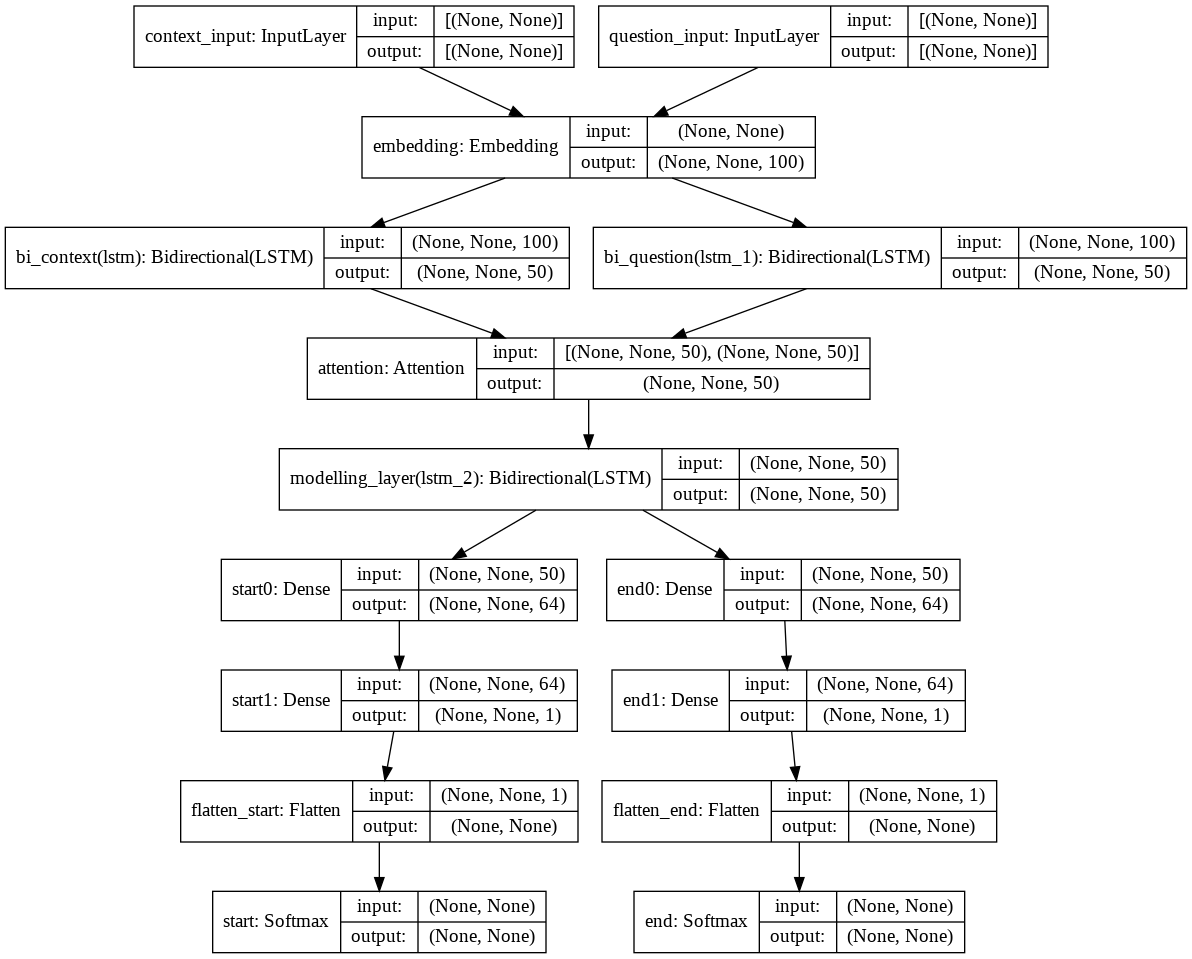

##BUILD

In [16]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Bidirectional, Attention, Flatten, Softmax

def build_model(rnn_units, learning_rate):
  # CONTEXT
  context_inputs = Input(shape=(None,), name='context_input')
  embedded_contexts = embedding_layer(context_inputs)
  bi_context = Bidirectional(LSTM(rnn_units, return_sequences=True), name='bi_context', merge_mode = 'sum')
  context_emb = bi_context(embedded_contexts)

  # QUESTION
  question_inputs = Input(shape=(None,), name='question_input')
  embedded_questions = embedding_layer(question_inputs)
  bi_question = Bidirectional(LSTM(rnn_units, return_sequences = True), name='bi_question', merge_mode = 'sum')
  question_emb = bi_question(embedded_questions)

  # ATTENTION
  att = Attention()([context_emb, question_emb])
  
  # FURTHER ELABORATION
  modelling_layer = Bidirectional(LSTM(rnn_units, return_sequences=True), name='modelling_layer', merge_mode = 'sum')(att)

  # START
  start = Dense(64, activation='relu', name='start0')(modelling_layer)
  start = Dense(1, activation='relu', name='start1')(start)
  start = Flatten(name='flatten_start')(start)
  out_start = Softmax(name='start')(start)

  # END
  end = Dense(64, activation='relu', name='end0')(modelling_layer)
  end = Dense(1, activation='relu', name='end1')(end)
  end = Flatten(name='flatten_end')(end)
  out_end = Softmax(name='end')(end)

  # LOSS FUNCTION, ACCURACY and OPTIMIZER DEFINITION
  loss = tf.keras.losses.CategoricalCrossentropy(from_logits=False, name='categorical_crossentropy')
  accuracy = tf.keras.metrics.CategoricalAccuracy(name='categorical_accuracy', dtype=None)
  opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)
  
  model = Model([question_inputs, context_inputs], [out_start, out_end])
  model.compile(optimizer=opt, loss=loss, metrics=accuracy)

  return model

##ACCURACY RESULTS 

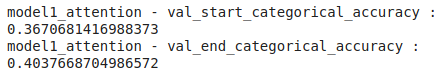

Screenshot_2021-05-18_00-41-25.png

#EXPERIMENT 1: NO LSTM AFTER ATTENTION

##BUILD

In [17]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Bidirectional, Attention, Flatten, Softmax

def build_model(rnn_units, learning_rate):
  # CONTEXT
  context_inputs = Input(shape=(None,), name='context_input')
  embedded_contexts = embedding_layer(context_inputs)
  bi_context = Bidirectional(LSTM(rnn_units, return_sequences=True), name='bi_context', merge_mode = 'sum')
  context_emb = bi_context(embedded_contexts)

  # QUESTION
  question_inputs = Input(shape=(None,), name='question_input')
  embedded_questions = embedding_layer(question_inputs)
  bi_question = Bidirectional(LSTM(rnn_units, return_sequences=True), name='bi_question', merge_mode = 'sum')
  question_emb = bi_question(embedded_questions)

  # ATTENTION
  att = Attention()([context_emb, question_emb])
  
  # START
  start = Dense(64, activation='relu', name='start0')(att)
  start = Dense(1, activation='relu', name='start1')(start)
  start = Flatten(name='flatten_start')(start)
  out_start = Softmax(name='start')(start)

  # END
  end = Dense(64, activation='relu', name='end0')(att)
  end = Dense(1, activation='relu', name='end1')(end)
  end = Flatten(name='flatten_end')(end)
  out_end = Softmax(name='end')(end)

  # LOSS FUNCTION, ACCURACY and OPTIMIZER DEFINITION
  loss = tf.keras.losses.CategoricalCrossentropy(from_logits=False, name='categorical_crossentropy')
  accuracy = tf.keras.metrics.CategoricalAccuracy(name='categorical_accuracy', dtype=None)
  opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)
  
  model = Model([question_inputs, context_inputs], [out_start, out_end])
  model.compile(optimizer=opt, loss=loss, metrics=accuracy)

  return model

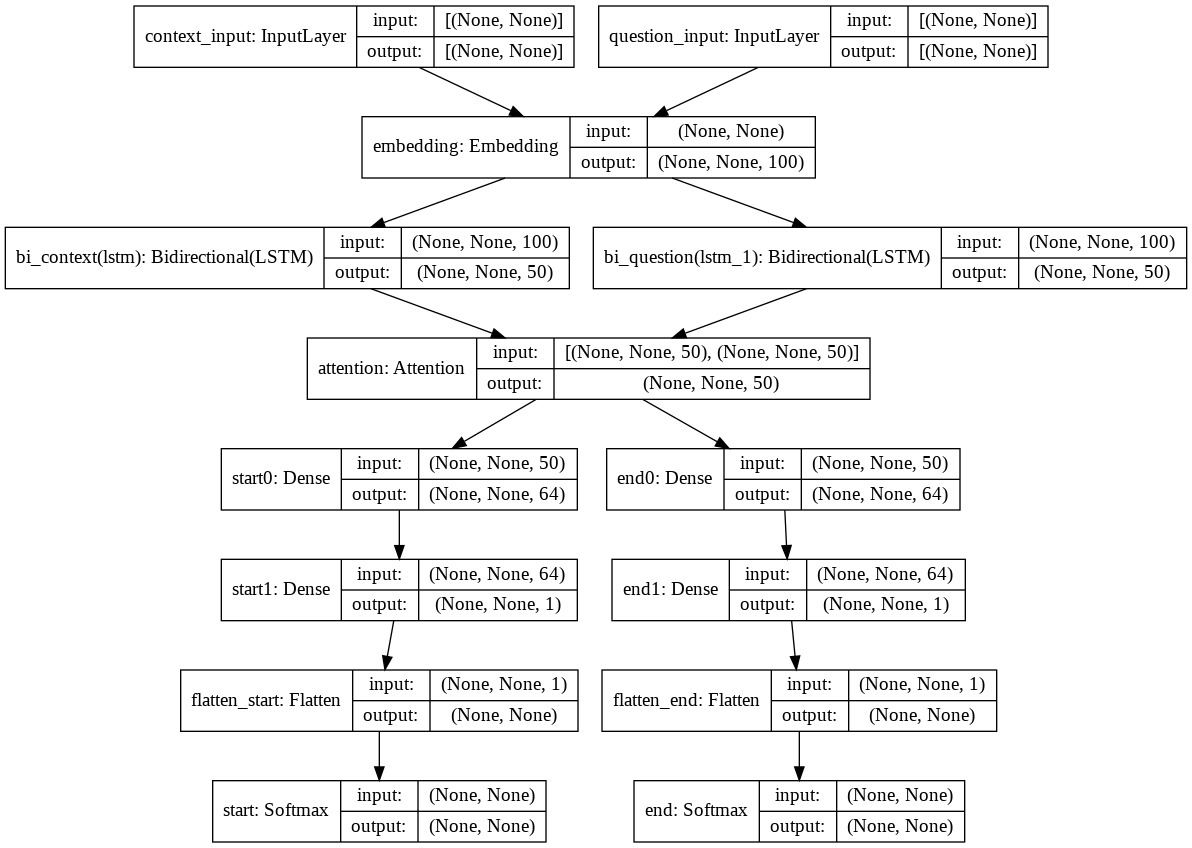

In [18]:
model = build_model(rnn_units, lrn_rate)
tf.keras.utils.plot_model(model, show_shapes=True)

In [19]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
context_input (InputLayer)      [(None, None)]       0                                            
__________________________________________________________________________________________________
question_input (InputLayer)     [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, None, 100)    7861700     context_input[0][0]              
                                                                 question_input[0][0]             
__________________________________________________________________________________________________
bi_context (Bidirectional)      (None, None, 50)     60400       embedding[0][0]              

FOR COMPARISON:

STANDARD MODEL1 - ATTENTION:

Total params: 8,029,458

Trainable params: 167,858

##TRAIN

Epoch 1/100
255/255 [==============================] - 50s 119ms/step - loss: 9.7938 - start_loss: 5.8747 - end_loss: 3.9191 - start_categorical_accuracy: 0.0265 - end_categorical_accuracy: 0.0845 - val_loss: 9.1349 - val_start_loss: 6.0661 - val_end_loss: 3.0688 - val_start_categorical_accuracy: 0.0329 - val_end_categorical_accuracy: 0.1983

Epoch 00001: val_loss improved from inf to 9.13492, saving model to ./models/models/experiment1.h5
Epoch 2/100
255/255 [==============================] - 29s 112ms/step - loss: 8.8790 - start_loss: 5.8729 - end_loss: 3.0061 - start_categorical_accuracy: 0.0264 - end_categorical_accuracy: 0.2059 - val_loss: 8.9026 - val_start_loss: 6.0661 - val_end_loss: 2.8365 - val_start_categorical_accuracy: 0.0329 - val_end_categorical_accuracy: 0.2360

Epoch 00002: val_loss improved from 9.13492 to 8.90264, saving model to ./models/models/experiment1.h5
Epoch 3/100
255/255 [==============================] - 29s 112ms/step - loss: 8.6506 - start_loss: 5.8830 - 

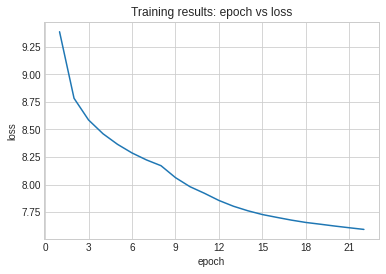

<Figure size 432x288 with 0 Axes>

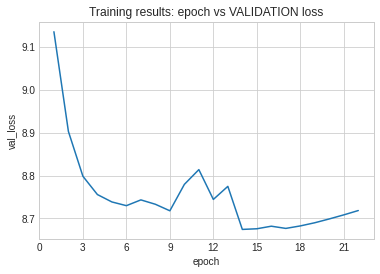

<Figure size 432x288 with 0 Axes>

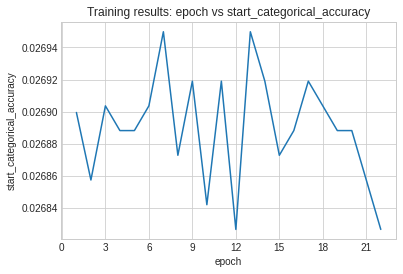

<Figure size 432x288 with 0 Axes>

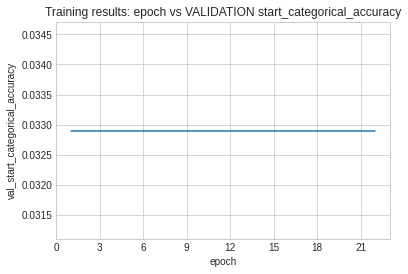

<Figure size 432x288 with 0 Axes>

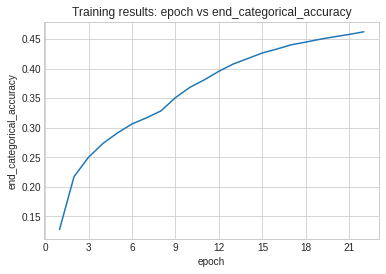

<Figure size 432x288 with 0 Axes>

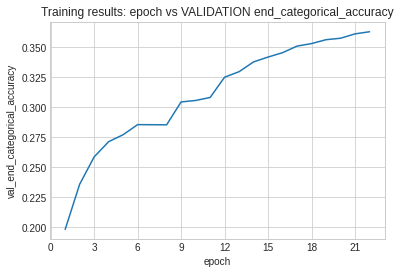

<Figure size 432x288 with 0 Axes>

In [20]:
model_name = "experiment1"

history = train_model(folder="./models", model=model, model_name=model_name,
                            train_data=load_data(df_train, btch_size), val_data=df_valENC, batch=btch_size, epochs=n_epochs)

##ACCURACY RESULTS 

In [21]:
val_start_categorical_accuracy = history.history['val_start_categorical_accuracy'][np.argmin(history.history['val_loss'])]
print(model_name, "- val_start_categorical_accuracy :", val_start_categorical_accuracy)
val_end_categorical_accuracy = history.history['val_end_categorical_accuracy'][np.argmin(history.history['val_loss'])]
print(model_name, "- val_end_categorical_accuracy :", val_end_categorical_accuracy)
mean = (val_start_categorical_accuracy+val_end_categorical_accuracy)/2
print(model_name, "- mean accuracy :", mean)

experiment1 - val_start_categorical_accuracy : 0.03289952129125595
experiment1 - val_end_categorical_accuracy : 0.3379678428173065
experiment1 - mean accuracy : 0.18543368205428123


##CONSIDERATIONS
- SLIGHTLY LOWER IN NUMBER OF TRAINABLE PARAMETERS

- TERRIBLE IN LEARNING THE START INDEX...

- COMPARABLE CATEGORICAL ACCURACY FOR THE END INDEX, BUT STILL LOWER THAN OUR STANDARD VERSION

=> WORSE THAN OUR STANDARD VERSION

#EXPERIMENT 2: NO LSTMs BEFORE ATTENTION

##BUILD

In [22]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Bidirectional, Attention, Flatten, Softmax

def build_model(rnn_units, learning_rate):
  # CONTEXT
  context_inputs = Input(shape=(None,), name='context_input')
  embedded_contexts = embedding_layer(context_inputs)
  #bi_context = Bidirectional(LSTM(rnn_units, return_sequences=True), name='bi_context', merge_mode = 'sum')
  #context_emb = bi_context(embedded_contexts)

  # QUESTION
  question_inputs = Input(shape=(None,), name='question_input')
  embedded_questions = embedding_layer(question_inputs)
  #bi_question = Bidirectional(LSTM(rnn_units, return_sequences=True), name='bi_question', merge_mode = 'sum')
  #question_emb = bi_question(embedded_questions)

  # ATTENTION
  att = Attention()([embedded_contexts, embedded_questions])
  
  # FURTHER ELABORATION
  modelling_layer = Bidirectional(LSTM(rnn_units, return_sequences=True), name='modelling_layer', merge_mode = 'sum')(att)
  
  # START
  start = Dense(64, activation='relu', name='start0')(modelling_layer)
  start = Dense(1, activation='relu', name='start1')(start)
  start = Flatten(name='flatten_start')(start)
  out_start = Softmax(name='start')(start)

  # END
  end = Dense(64, activation='relu', name='end0')(modelling_layer)
  end = Dense(1, activation='relu', name='end1')(end)
  end = Flatten(name='flatten_end')(end)
  out_end = Softmax(name='end')(end)

  # LOSS FUNCTION, ACCURACY and OPTIMIZER DEFINITION
  loss = tf.keras.losses.CategoricalCrossentropy(from_logits=False, name='categorical_crossentropy')
  accuracy = tf.keras.metrics.CategoricalAccuracy(name='categorical_accuracy', dtype=None)
  opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)
  
  model = Model([question_inputs, context_inputs], [out_start, out_end])
  model.compile(optimizer=opt, loss=loss, metrics=accuracy)

  return model

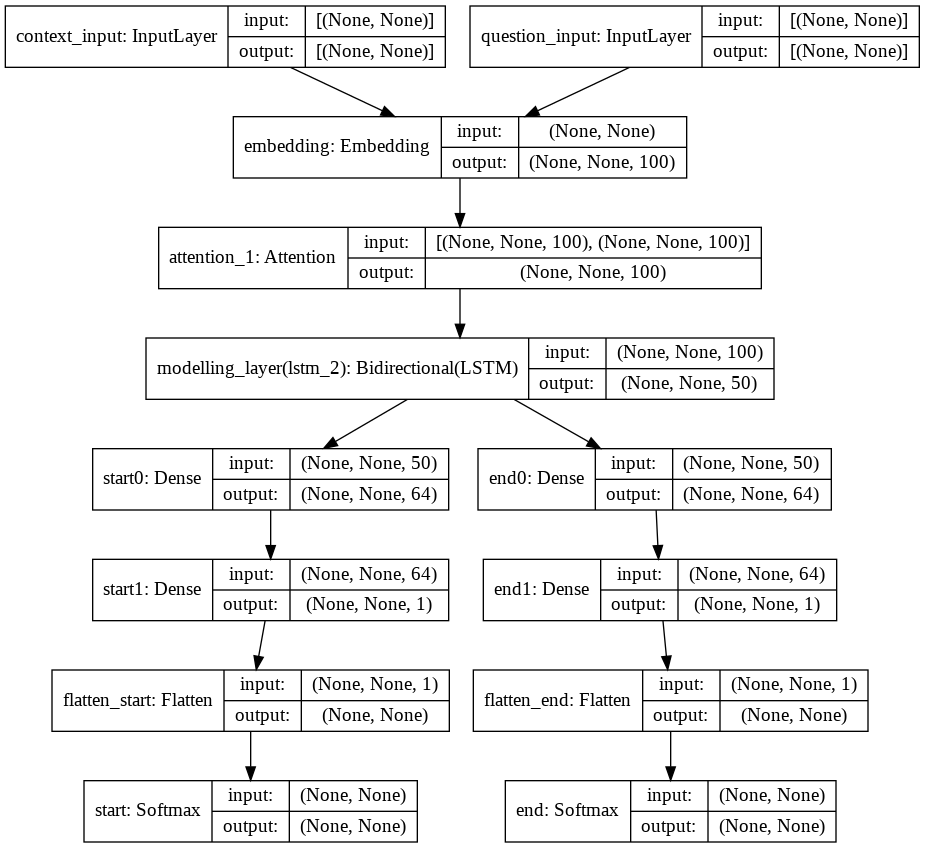

In [23]:
model = build_model(rnn_units, lrn_rate)
tf.keras.utils.plot_model(model, show_shapes=True)

In [24]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
context_input (InputLayer)      [(None, None)]       0                                            
__________________________________________________________________________________________________
question_input (InputLayer)     [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, None, 100)    7861700     context_input[0][0]              
                                                                 question_input[0][0]             
__________________________________________________________________________________________________
attention_1 (Attention)         (None, None, 100)    0           embedding[2][0]            

FOR COMPARISON:

STANDARD MODEL1 - ATTENTION:

Total params: 8,029,458

Trainable params: 167,858

##TRAIN

Epoch 1/100
255/255 [==============================] - 31s 110ms/step - loss: 8.5644 - start_loss: 4.3286 - end_loss: 4.2358 - start_categorical_accuracy: 0.0652 - end_categorical_accuracy: 0.0694 - val_loss: 7.4863 - val_start_loss: 3.8044 - val_end_loss: 3.6820 - val_start_categorical_accuracy: 0.1301 - val_end_categorical_accuracy: 0.1389

Epoch 00001: val_loss improved from inf to 7.48634, saving model to ./models/models/experiment2.h5
Epoch 2/100
255/255 [==============================] - 27s 106ms/step - loss: 7.3633 - start_loss: 3.7365 - end_loss: 3.6268 - start_categorical_accuracy: 0.1407 - end_categorical_accuracy: 0.1435 - val_loss: 7.0123 - val_start_loss: 3.5638 - val_end_loss: 3.4485 - val_start_categorical_accuracy: 0.1698 - val_end_categorical_accuracy: 0.1804

Epoch 00002: val_loss improved from 7.48634 to 7.01231, saving model to ./models/models/experiment2.h5
Epoch 3/100
255/255 [==============================] - 27s 106ms/step - loss: 7.0322 - start_loss: 3.5693 - 

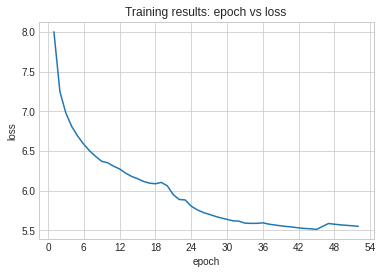

<Figure size 432x288 with 0 Axes>

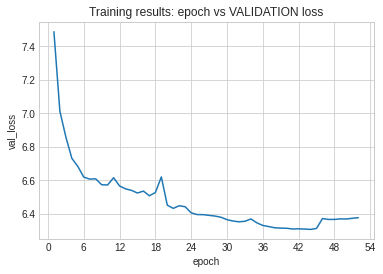

<Figure size 432x288 with 0 Axes>

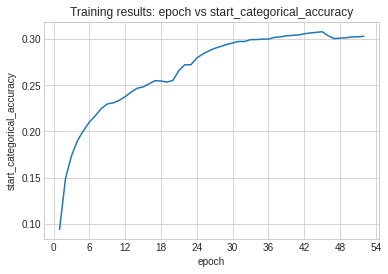

<Figure size 432x288 with 0 Axes>

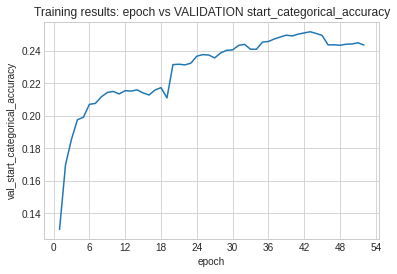

<Figure size 432x288 with 0 Axes>

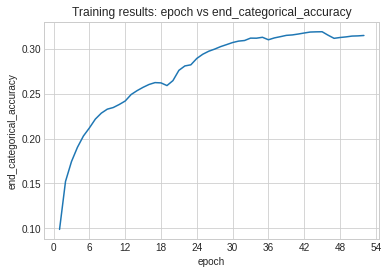

<Figure size 432x288 with 0 Axes>

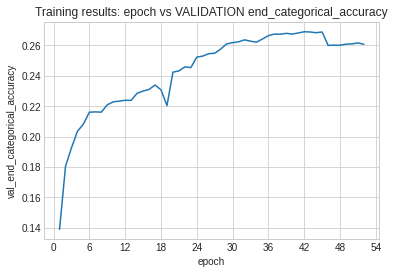

<Figure size 432x288 with 0 Axes>

In [25]:
model_name = "experiment2"

history = train_model(folder="./models", model=model, model_name=model_name,
                            train_data=load_data(df_train, btch_size), val_data=df_valENC, batch=btch_size, epochs=n_epochs)

##ACCURACY RESULTS 

In [26]:
val_start_categorical_accuracy = history.history['val_start_categorical_accuracy'][np.argmin(history.history['val_loss'])]
print(model_name, "- val_start_categorical_accuracy :", val_start_categorical_accuracy)
val_end_categorical_accuracy = history.history['val_end_categorical_accuracy'][np.argmin(history.history['val_loss'])]
print(model_name, "- val_end_categorical_accuracy :", val_end_categorical_accuracy)
mean = (val_start_categorical_accuracy+val_end_categorical_accuracy)/2
print(model_name, "- mean accuracy :", mean)

experiment2 - val_start_categorical_accuracy : 0.25058606266975403
experiment2 - val_end_categorical_accuracy : 0.26836958527565
experiment2 - mean accuracy : 0.259477823972702


##CONSIDERATIONS

- NUMBER OF TRAINABLE PARAMETERS MUCH SMALLER

- QUITE BALANCED IN CAPABILITY OF LEARNING BOTH START AND END INDEXES, BUT CATEGORICAL ACCURACY VALUES ARE LOWER THAN IN THE STANDARD VERSION

=> WORSE THAN OUR STANDARD VERSION

#EXPERIMENT 3: GRU INSTEAD OF LSTM

##BUILD

In [27]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GRU, Dense, Bidirectional, Attention, Flatten, Softmax

def build_model(rnn_units, learning_rate):
  # CONTEXT
  context_inputs = Input(shape=(None,), name='context_input')
  embedded_contexts = embedding_layer(context_inputs)
  context_emb = Bidirectional(GRU(rnn_units, return_sequences=True), name='biGRU_context')(embedded_contexts)

  # QUESTION
  question_inputs = Input(shape=(None,), name='question_input')
  embedded_questions = embedding_layer(question_inputs)
  question_emb = Bidirectional(GRU(rnn_units, return_sequences=True), name='biGRU_question')(embedded_questions)

  # ATTENTION
  att = Attention()([embedded_contexts, embedded_questions])
  
  # FURTHER ELABORATION
  modelling_layer = Bidirectional(GRU(rnn_units, return_sequences=True), name='modelling_layer', merge_mode = 'sum')(att)
  
  # START
  start = Dense(64, activation='relu', name='start0')(modelling_layer)
  start = Dense(1, activation='relu', name='start1')(start)
  start = Flatten(name='flatten_start')(start)
  out_start = Softmax(name='start')(start)

  # END
  end = Dense(64, activation='relu', name='end0')(modelling_layer)
  end = Dense(1, activation='relu', name='end1')(end)
  end = Flatten(name='flatten_end')(end)
  out_end = Softmax(name='end')(end)

  # LOSS FUNCTION, ACCURACY and OPTIMIZER DEFINITION
  loss = tf.keras.losses.CategoricalCrossentropy(from_logits=False, name='categorical_crossentropy')
  accuracy = tf.keras.metrics.CategoricalAccuracy(name='categorical_accuracy', dtype=None)
  opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)
  
  model = Model([question_inputs, context_inputs], [out_start, out_end])
  model.compile(optimizer=opt, loss=loss, metrics=accuracy)

  return model

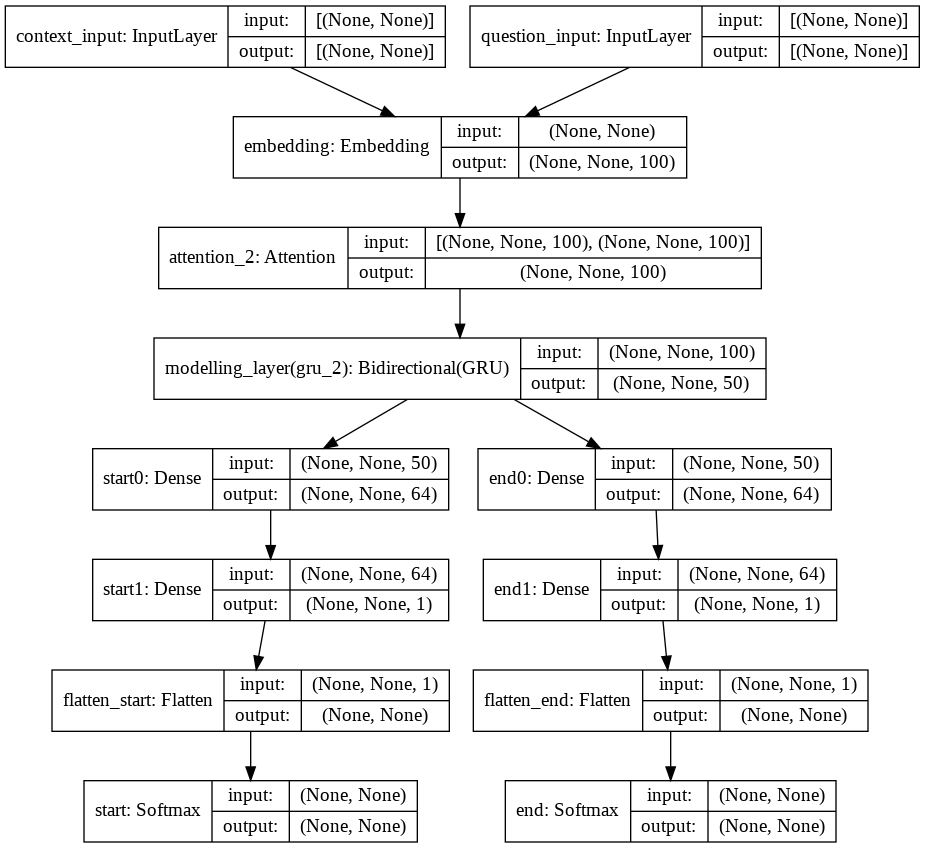

In [28]:
model = build_model(rnn_units, lrn_rate)
tf.keras.utils.plot_model(model, show_shapes=True)

In [29]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
context_input (InputLayer)      [(None, None)]       0                                            
__________________________________________________________________________________________________
question_input (InputLayer)     [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, None, 100)    7861700     context_input[0][0]              
                                                                 question_input[0][0]             
__________________________________________________________________________________________________
attention_2 (Attention)         (None, None, 100)    0           embedding[4][0]            

FOR COMPARISON:

STANDARD MODEL1 - ATTENTION:

Total params: 8,029,458

Trainable params: 167,858

##TRAIN

Epoch 1/100
255/255 [==============================] - 31s 110ms/step - loss: 8.3896 - start_loss: 4.2381 - end_loss: 4.1515 - start_categorical_accuracy: 0.0753 - end_categorical_accuracy: 0.0808 - val_loss: 7.2124 - val_start_loss: 3.6668 - val_end_loss: 3.5456 - val_start_categorical_accuracy: 0.1519 - val_end_categorical_accuracy: 0.1595

Epoch 00001: val_loss improved from inf to 7.21243, saving model to ./models/models/experiment3.h5
Epoch 2/100
255/255 [==============================] - 27s 107ms/step - loss: 7.2256 - start_loss: 3.6619 - end_loss: 3.5637 - start_categorical_accuracy: 0.1516 - end_categorical_accuracy: 0.1503 - val_loss: 6.8961 - val_start_loss: 3.5221 - val_end_loss: 3.3740 - val_start_categorical_accuracy: 0.1762 - val_end_categorical_accuracy: 0.1865

Epoch 00002: val_loss improved from 7.21243 to 6.89613, saving model to ./models/models/experiment3.h5
Epoch 3/100
255/255 [==============================] - 27s 107ms/step - loss: 6.9175 - start_loss: 3.5123 - 

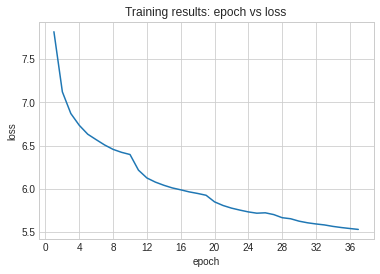

<Figure size 432x288 with 0 Axes>

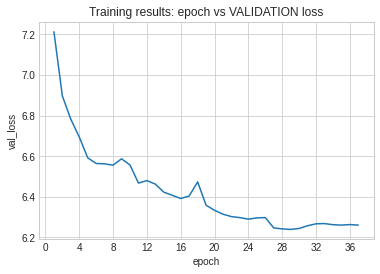

<Figure size 432x288 with 0 Axes>

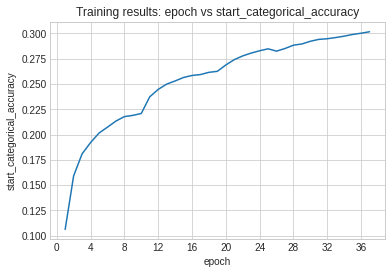

<Figure size 432x288 with 0 Axes>

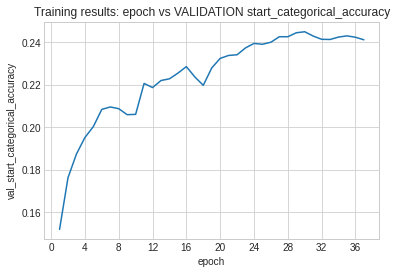

<Figure size 432x288 with 0 Axes>

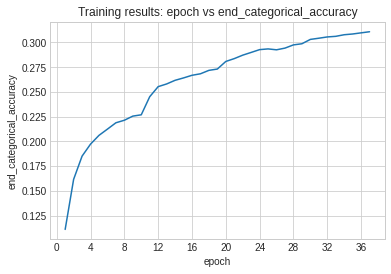

<Figure size 432x288 with 0 Axes>

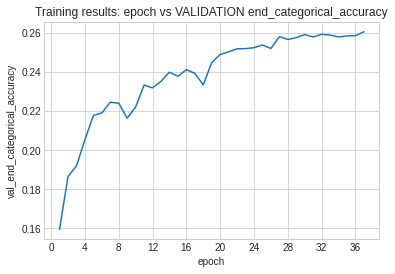

<Figure size 432x288 with 0 Axes>

In [30]:
model_name = "experiment3"

history = train_model(folder="./models", model=model, model_name=model_name,
                            train_data=load_data(df_train, btch_size), val_data=df_valENC, batch=btch_size, epochs=n_epochs)

##ACCURACY RESULTS 

In [31]:
val_start_categorical_accuracy = history.history['val_start_categorical_accuracy'][np.argmin(history.history['val_loss'])]
print(model_name, "- val_start_categorical_accuracy :", val_start_categorical_accuracy)
val_end_categorical_accuracy = history.history['val_end_categorical_accuracy'][np.argmin(history.history['val_loss'])]
print(model_name, "- val_end_categorical_accuracy :", val_end_categorical_accuracy)
mean = (val_start_categorical_accuracy+val_end_categorical_accuracy)/2
print(model_name, "- mean accuracy :", mean)

experiment3 - val_start_categorical_accuracy : 0.2444426417350769
experiment3 - val_end_categorical_accuracy : 0.25761863589286804
experiment3 - mean accuracy : 0.2510306388139725


##CONSIDERATIONS

- STRONG REDUCTION TO THE NUMBER OF TRAINABLE PARAMETERS

- QUITE BALANCED IN CAPABILITY OF LEARNING BOTH START AND END INDEXES, BUT CATEGORICAL ACCURACY VALUES ARE LOWER THAN IN THE STANDARD VERSION

=> WORSE THAN OUR STANDARD VERSION

#EXPERIMENT 4: LSTM WITH DROP OUT

In [32]:
drp = 0.2

##BUILD

In [33]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Bidirectional, Attention, Flatten, Softmax

def build_model(rnn_units, learning_rate):
  # CONTEXT
  context_inputs = Input(shape=(None,), name='context_input')
  embedded_contexts = embedding_layer(context_inputs)
  bi_context = Bidirectional(LSTM(rnn_units, dropout=drp, return_sequences=True), name='bi_context', merge_mode = 'sum')
  context_emb = bi_context(embedded_contexts)

  # QUESTION
  question_inputs = Input(shape=(None,), name='question_input')
  embedded_questions = embedding_layer(question_inputs)
  bi_question = Bidirectional(LSTM(rnn_units, dropout=drp, return_sequences=True), name='bi_question', merge_mode = 'sum')
  question_emb = bi_question(embedded_questions)

  # ATTENTION
  att = Attention()([context_emb, question_emb])
  
  # FURTHER ELABORATION
  modelling_layer = Bidirectional(LSTM(rnn_units, dropout=drp, return_sequences=True), name='modelling_layer', merge_mode = 'sum')(att)
  
  # START
  start = Dense(64, activation='relu', name='start0')(modelling_layer)
  start = Dense(1, activation='relu', name='start1')(start)
  start = Flatten(name='flatten_start')(start)
  out_start = Softmax(name='start')(start)

  # END
  end = Dense(64, activation='relu', name='end0')(modelling_layer)
  end = Dense(1, activation='relu', name='end1')(end)
  end = Flatten(name='flatten_end')(end)
  out_end = Softmax(name='end')(end)

  # LOSS FUNCTION, ACCURACY and OPTIMIZER DEFINITION
  loss = tf.keras.losses.CategoricalCrossentropy(from_logits=False, name='categorical_crossentropy')
  accuracy = tf.keras.metrics.CategoricalAccuracy(name='categorical_accuracy', dtype=None)
  opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)
  
  model = Model([question_inputs, context_inputs], [out_start, out_end])
  model.compile(optimizer=opt, loss=loss, metrics=accuracy)

  return model

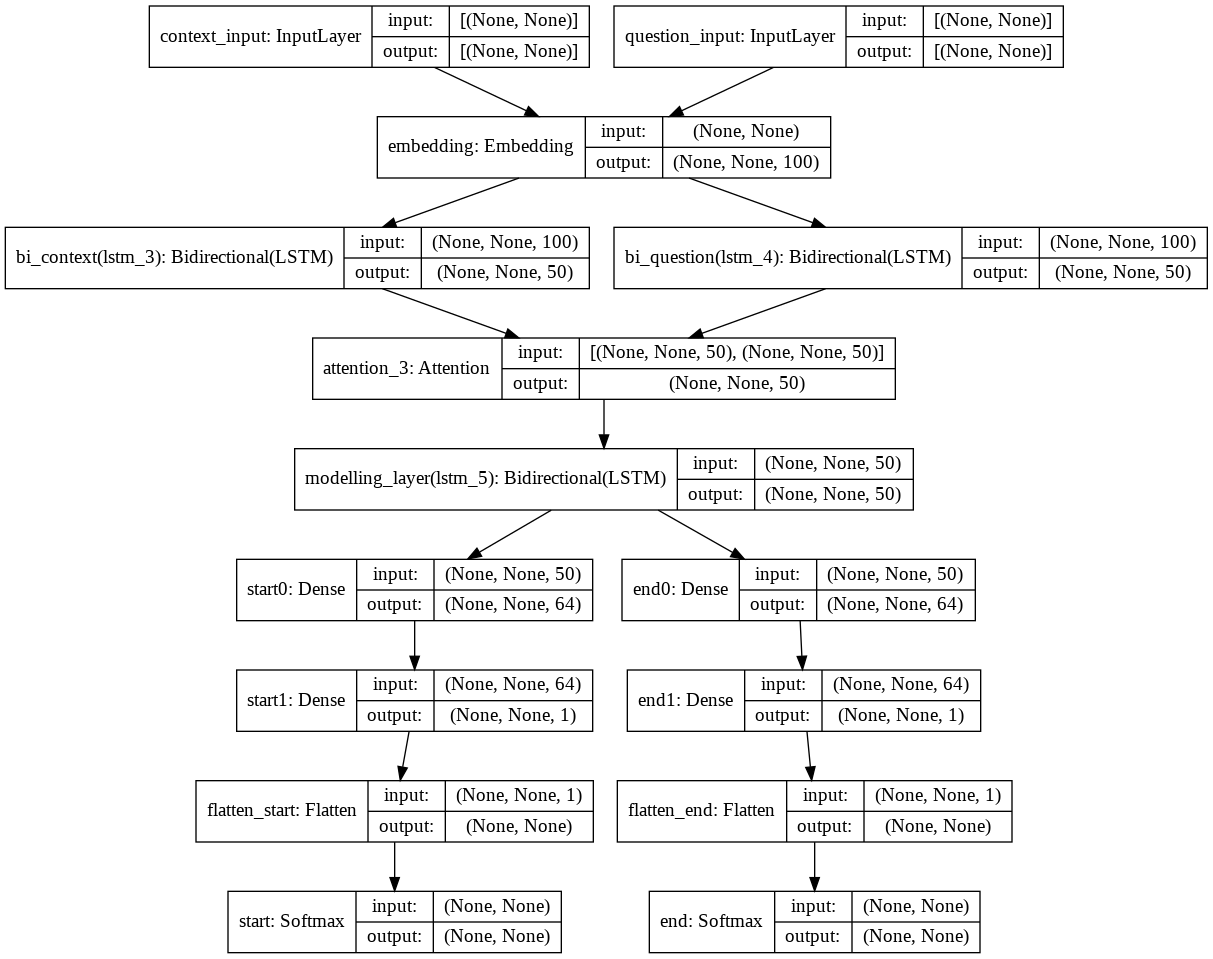

In [34]:
model = build_model(rnn_units, lrn_rate)
tf.keras.utils.plot_model(model, show_shapes=True)

In [35]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
context_input (InputLayer)      [(None, None)]       0                                            
__________________________________________________________________________________________________
question_input (InputLayer)     [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, None, 100)    7861700     context_input[0][0]              
                                                                 question_input[0][0]             
__________________________________________________________________________________________________
bi_context (Bidirectional)      (None, None, 50)     60400       embedding[6][0]            

FOR COMPARISON:

STANDARD MODEL1 - ATTENTION:

Total params: 8,029,458

Trainable params: 167,858

##TRAIN

Epoch 1/100
255/255 [==============================] - 58s 199ms/step - loss: 8.3505 - start_loss: 4.2575 - end_loss: 4.0930 - start_categorical_accuracy: 0.0753 - end_categorical_accuracy: 0.0803 - val_loss: 6.3646 - val_start_loss: 3.3498 - val_end_loss: 3.0148 - val_start_categorical_accuracy: 0.2012 - val_end_categorical_accuracy: 0.2160

Epoch 00001: val_loss improved from inf to 6.36457, saving model to ./models/models/experiment4.h5
Epoch 2/100
255/255 [==============================] - 49s 192ms/step - loss: 6.3967 - start_loss: 3.3349 - end_loss: 3.0618 - start_categorical_accuracy: 0.1956 - end_categorical_accuracy: 0.2088 - val_loss: 6.0095 - val_start_loss: 3.1750 - val_end_loss: 2.8345 - val_start_categorical_accuracy: 0.2308 - val_end_categorical_accuracy: 0.2535

Epoch 00002: val_loss improved from 6.36457 to 6.00952, saving model to ./models/models/experiment4.h5
Epoch 3/100
255/255 [==============================] - 49s 192ms/step - loss: 6.0488 - start_loss: 3.1551 - 

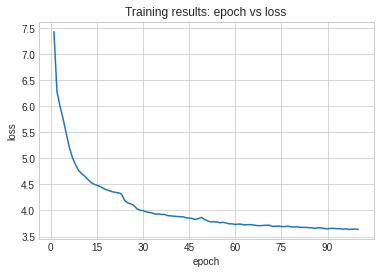

<Figure size 432x288 with 0 Axes>

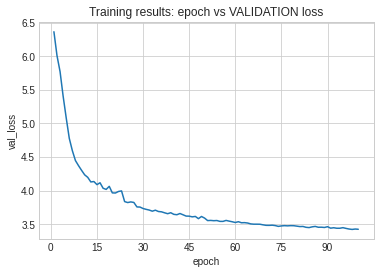

<Figure size 432x288 with 0 Axes>

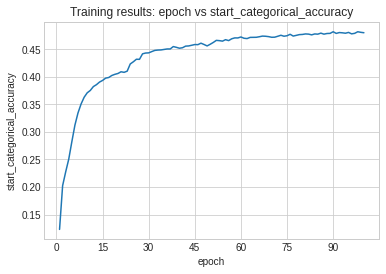

<Figure size 432x288 with 0 Axes>

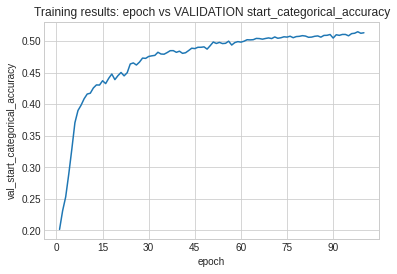

<Figure size 432x288 with 0 Axes>

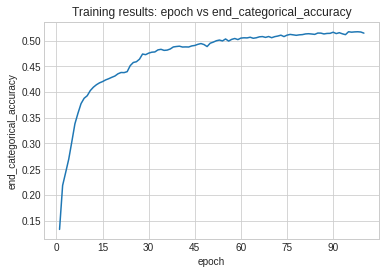

<Figure size 432x288 with 0 Axes>

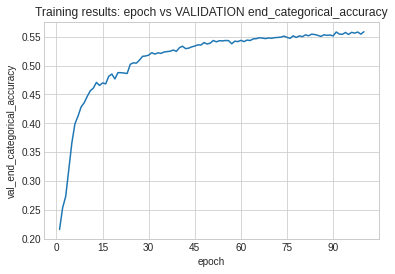

<Figure size 432x288 with 0 Axes>

In [36]:
model_name = "experiment4"

history = train_model(folder="./models", model=model, model_name=model_name,
                            train_data=load_data(df_train, btch_size), val_data=df_valENC, batch=btch_size, epochs=n_epochs)

##ACCURACY RESULTS 

In [37]:
val_start_categorical_accuracy = history.history['val_start_categorical_accuracy'][np.argmin(history.history['val_loss'])]
print(model_name, "- val_start_categorical_accuracy :", val_start_categorical_accuracy)
val_end_categorical_accuracy = history.history['val_end_categorical_accuracy'][np.argmin(history.history['val_loss'])]
print(model_name, "- val_end_categorical_accuracy :", val_end_categorical_accuracy)
mean = (val_start_categorical_accuracy+val_end_categorical_accuracy)/2
print(model_name, "- mean accuracy :", mean)

experiment4 - val_start_categorical_accuracy : 0.5149139165878296
experiment4 - val_end_categorical_accuracy : 0.5580793619155884
experiment4 - mean accuracy : 0.536496639251709


##CONSIDERATIONS

- OF COURSE, SAME NUMBER OF TRAINABLE PARAMETERS

- IT NEEDS MANY EPOCHS MORE TO REACH ITS BEST

- IT INCREASES CATEGORICAL ACCURACY OVER VALIDATION THAN OVER TRAIN SET, PROBABLY DUE TO DROP-OUT'S CAPABILITY TO DISCOURAGE OVERFITTING

=> COMPARABLE TO OUR STANDARD VERSION (AND EVEN BETTER)

#CONCLUSIONS

BEST ONES ARE 

- STANDARD :
    - val_start_categorical_accuracy : 0.3670681416988373
    - val_end_categorical_accuracy : 0.4037668704986572
    - mean accuracy : 0.38541750609874725

- experiment4 (like standard but with drop_out=0.2) :
    - val_start_categorical_accuracy : 0.5149139165878296
    - val_end_categorical_accuracy : 0.5580793619155884
    - mean accuracy : 0.536496639251709


WE DECIDE TO KEEP OUR STANDARD VERSION AND TO ADD THE PREDICTION WITH THE EXPERIMENT4 MODEL.